# Team 6 - Web Scraping Amazon Reviews on TOZO W1 Wireless Charger

Team 6: Lai Leng Chan, Minsu Kim, Christopher Garcia

Objective:

## API Scraping & Data Ingestion

In [2]:
# Importing necessary libraries
import os
import pandas as pd
import datetime
import re
import requests
import time
import emoji

from bs4 import BeautifulSoup
from collections import defaultdict, Counter
import random
from urllib.parse import urlencode

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [37]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# After inspecting the HTML of the review page, we can see that the HTML line which we are trying 
# to scrape and extract follows the below format:
# <span class="a-profile-name">Nick</span>
# where span is the tag for the HTML line and the class is "a-profile-name"

# Define the list of URL that will be scraped

# Define the base URL
base_url = 'https://www.amazon.com/TOZO-Wireless-Upgraded-Sleep-Friendly-FastCharging/product-reviews/B07FM8R7J1/ref=cm_cr_getr_d_paging_btm_next_{}?ie=UTF8&reviewerType=all_reviews&pageNumber={}'

# Set the desired maximum number of pages
max_pages = 500  

# Generate the list of URLs
list_of_urls = [base_url.format(page_number, page_number) for page_number in range(1, max_pages + 1)]

In [ ]:
# Retrieve each of the url's HTML data and convert the data into a beautiful soup object
# Find, extract and store reviewer names and review text into a list

# We will extract the data from the webpage via ScrapeAPI

reviews = []
star_ratings = []
data_string = ""

for url in list_of_urls: 
    params = {'api_key': "1327eb1bf20892837140fb2ade3f0714", 'url': url}
    response = requests.get('http://api.scraperapi.com/',   params=urlencode(params))
    soup = BeautifulSoup(response.text, 'html.parser')

    for item in soup.find_all("span", {"data-hook": "review-body"}):
      data_string = data_string + item.get_text()
      reviews.append(data_string)
      data_string = ""
    
    for item in soup.find_all("i", {"data-hook": "review-star-rating"}):
      star_ratings.append(item.get_text())

In [ ]:
# Let's set up a dictionary to hold our customer names and reviews
reviews_dict = {'Reviews': reviews, 'Star Ratings': star_ratings}

# Print the lengths of each list.  
print(len(star_ratings), len(reviews))

In [ ]:
# Convert the dictionary to a DataFrame
reviews_df = pd.DataFrame.from_dict(reviews_dict, orient='index')

# Convert dataframe to CSV file for easier assess in the future
reviews_df.to_csv('reviews.csv', index=False, header=True)

In [ ]:
reviews_df

## Data Proprocessing

In [4]:
# Reading the downloaded raw data into a dataframe
reviews_df = pd.read_csv('reviews.csv')
reviews_df

,0,1,2,3,4,5,6,7,8,9,...,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799
0,"\nFirst, this charger looks fantastic. I got t...",\nUPDATE: Well...I was wrong about this wirel...,\nThis works perfectly on the side table while...,\nI purchased this charger for use in our camp...,"\nGot this for my Samsung Galaxy S23 phone, an...",\nI ordered this charger after using one at my...,\nCame here to see if there was any tips on ho...,\nDevice must be placed carefully or it will f...,\nCharges like advertised. I did have to take ...,\nI wanted something to use instead of the typ...,...,"\nEven with Magsafe case on, charging is super...",\nGreat charger! Able to charge my phone easil...,\nBought two of these and one was giving me pr...,\nI saw this on one of my colleagues desk at w...,\nAn excellent product. It’s in our kitchen as...,\nIt’s PERFECT for traveling. No more differen...,\n\n\n\n\n The media could ...,\nImpressed taking it out of the box. All met...,\nI love the design of this charger. Color on ...,\nkinda finnicky cuz ur phone has to be in the...
1,4.0 out of 5 stars,5.0 out of 5 stars,5.0 out of 5 stars,5.0 out of 5 stars,5.0 out of 5 stars,4.0 out of 5 stars,5.0 out of 5 stars,4.0 out of 5 stars,5.0 out of 5 stars,5.0 out of 5 stars,...,5.0 out of 5 stars,5.0 out of 5 stars,5.0 out of 5 stars,5.0 out of 5 stars,5.0 out of 5 stars,5.0 out of 5 stars,5.0 out of 5 stars,5.0 out of 5 stars,3.0 out of 5 stars,4.0 out of 5 stars


In [5]:
# Transposing the dataframe for easier visualization
reviews_df = reviews_df.transpose()
reviews_df = reviews_df.reset_index(drop=True)
reviews_df.columns = ['Review', 'Star Rating']
reviews_df

,Review,Star Rating
0,"\nFirst, this charger looks fantastic. I got t...",4.0 out of 5 stars
1,\nUPDATE: Well...I was wrong about this wirel...,5.0 out of 5 stars
2,\nThis works perfectly on the side table while...,5.0 out of 5 stars
3,\nI purchased this charger for use in our camp...,5.0 out of 5 stars
4,"\nGot this for my Samsung Galaxy S23 phone, an...",5.0 out of 5 stars
...,...,...
4795,\nIt’s PERFECT for traveling. No more differen...,5.0 out of 5 stars
4796,\n\n\n\n\n The media could ...,5.0 out of 5 stars
4797,\nImpressed taking it out of the box. All met...,5.0 out of 5 stars
4798,\nI love the design of this charger. Color on ...,3.0 out of 5 stars


In [6]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

In [7]:
# Descriptive Statistics Function

def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    
    if verbose :        
        print(f"There are {len(tokens)} tokens in the data.")
        print(f"There are {len(set(tokens))} unique tokens in the data.")
        print(f"There are {len(''.join(tokens))} characters in the data.")
        print(f"The lexical diversity is {len(set(tokens))/len(tokens):.3f} in the data.")
    
        # print the five most common tokens
        counts = Counter(tokens)
        
        if num_tokens > 0:
            print(counts.most_common(num_tokens))
        
    return([len(tokens), 
            len(set(tokens)),
            len("".join(tokens)),
            len(set(tokens))/len(tokens)])    
    
    return(0)

In [8]:
# Data cleaning functions
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    tokens = text.split()
    tokens = [token.strip() for token in tokens]
    return tokens

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

In [9]:
# Apply the `pipeline` to the dataframe
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

reviews_df["tokens"] = reviews_df["Review"].apply(prepare,pipeline=my_pipeline)
reviews_df["num_tokens"] = reviews_df["tokens"].map(len) 

In [10]:
reviews_df

,Review,Star Rating,tokens,num_tokens
0,"\nFirst, this charger looks fantastic. I got t...",4.0 out of 5 stars,"[first, this, charger, looks, fantastic, i, go...",354
1,\nUPDATE: Well...I was wrong about this wirel...,5.0 out of 5 stars,"[update, welli, was, wrong, about, this, wirel...",822
2,\nThis works perfectly on the side table while...,5.0 out of 5 stars,"[this, works, perfectly, on, the, side, table,...",65
3,\nI purchased this charger for use in our camp...,5.0 out of 5 stars,"[i, purchased, this, charger, for, use, in, ou...",49
4,"\nGot this for my Samsung Galaxy S23 phone, an...",5.0 out of 5 stars,"[got, this, for, my, samsung, galaxy, s23, pho...",154
...,...,...,...,...
4795,\nIt’s PERFECT for traveling. No more differen...,5.0 out of 5 stars,"[it’s, perfect, for, traveling, no, more, diff...",22
4796,\n\n\n\n\n The media could ...,5.0 out of 5 stars,"[the, media, could, not, be, loaded, this, is,...",48
4797,\nImpressed taking it out of the box. All met...,5.0 out of 5 stars,"[impressed, taking, it, out, of, the, box, all...",47
4798,\nI love the design of this charger. Color on ...,3.0 out of 5 stars,"[i, love, the, design, of, this, charger, colo...",47


In [11]:
# Calls to descriptive_stats
descriptive_stats(reviews_df, num_tokens=10)

There are 4800 tokens in the data.
There are 4 unique tokens in the data.
There are 33 characters in the data.
The lexical diversity is 0.001 in the data.
[('Review', 1), ('Star Rating', 1), ('tokens', 1), ('num_tokens', 1)]


[4800, 4, 33, 0.0008333333333333334]

In [12]:
# transform data into list of tokens
reviews_descs = reviews_df.tokens.to_list()
reviews_descs = [item for sublist in reviews_descs for item in sublist]

In [13]:
descriptive_stats(reviews_descs,num_tokens=10)

There are 246944 tokens in the data.
There are 8290 unique tokens in the data.
There are 1027117 characters in the data.
The lexical diversity is 0.034 in the data.
[('the', 10379), ('it', 9292), ('i', 7803), ('and', 7527), ('to', 7009), ('a', 5860), ('my', 5121), ('is', 4464), ('this', 3721), ('charger', 3544)]


[246944, 8290, 1027117, 0.03357036413113904]

In [ ]:
## reviews_ct = Counter(reviews_df)
## reviews_descs_ct = Counter(reviews_descs)

## consideration_tokens = {w for w, c in reviews_df.items() if c >= 5}

##for ct in [reviews_desc_ct] :
##    consideration_tokens = consideration_tokens.intersection({w for w, c in ct.items if c >= 5})

In [14]:
def get_top_tokens(counter,reference_counters,allowed_tokens,top_n=10) :
    """
        Given a counter and a set of allowable tokens, get the top_n tokens
        for the counter and print them. "Top" here is defined as having the 
        maximum ratio of presence in a given counter compared to the sum of the
        other counters. 
    """
    
    comparison = Counter()
    results = defaultdict(float)
    
    for ct in reference_counters :
        comparison += ct
        
    for token, count in counter.items() : 
        if token in allowed_tokens : 
            results[token] = count/comparison[token]
    
    # found this nifty trick here: https://stackoverflow.com/questions/11902665/top-values-from-dictionary
    results = sorted([(k,v) for k, v in results.items()],key=lambda x: x[1])[-top_n:]
    
    return(results)

In [15]:
# wordclouds

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

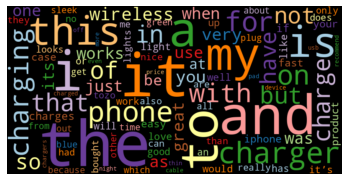

In [16]:
word_count = count_words(reviews_df)
wordcloud(word_count['freq'], max_words=100, stopwords=None)

In [17]:
# converting 'Star Ratings' column to numerical values

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
reviews_df[['Star Rating']] = encoder.fit_transform(reviews_df[['Star Rating']])
reviews_df

,Review,Star Rating,tokens,num_tokens
0,"\nFirst, this charger looks fantastic. I got t...",3.0,"[first, this, charger, looks, fantastic, i, go...",354
1,\nUPDATE: Well...I was wrong about this wirel...,4.0,"[update, welli, was, wrong, about, this, wirel...",822
2,\nThis works perfectly on the side table while...,4.0,"[this, works, perfectly, on, the, side, table,...",65
3,\nI purchased this charger for use in our camp...,4.0,"[i, purchased, this, charger, for, use, in, ou...",49
4,"\nGot this for my Samsung Galaxy S23 phone, an...",4.0,"[got, this, for, my, samsung, galaxy, s23, pho...",154
...,...,...,...,...
4795,\nIt’s PERFECT for traveling. No more differen...,4.0,"[it’s, perfect, for, traveling, no, more, diff...",22
4796,\n\n\n\n\n The media could ...,4.0,"[the, media, could, not, be, loaded, this, is,...",48
4797,\nImpressed taking it out of the box. All met...,4.0,"[impressed, taking, it, out, of, the, box, all...",47
4798,\nI love the design of this charger. Color on ...,2.0,"[i, love, the, design, of, this, charger, colo...",47


In [18]:
# after the ordinal encoding, star ratings are now from 0 to 4 (0 being 1 star, 4 being 5 stars)
print(min(reviews_df['Star Rating']))
print(max(reviews_df['Star Rating']))

0.0
4.0


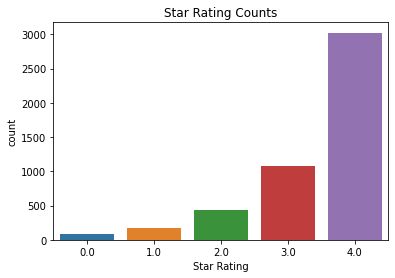

In [19]:
sns.countplot(reviews_df['Star Rating'])
reviews_df['Star Rating'].value_counts()
plt.title("Star Rating Counts")
plt.show()

In [20]:
#Identify positive and negative reviews based on star rating
#Count frequency of tokens used in each dataset
cv = CountVectorizer()
cv.fit(reviews_df['Review'].values.astype('U'))
neg_doc_matrix = cv.transform(reviews_df[reviews_df['Star Rating'] == 4.0].Review)
pos_doc_matrix = cv.transform(reviews_df[reviews_df['Star Rating'] == 0.0].Review)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],
                            columns=cv.get_feature_names()
                           ).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', 
                         ascending=False
                        ).iloc[:10]

,negative,positive,total
the,6838,346,7184
it,6855,319,7174
and,5353,200,5553
to,4409,209,4618
my,3562,151,3713
is,3023,103,3126
this,2677,111,2788
charger,2503,120,2623
for,2044,91,2135
phone,1976,146,2122


## Modeling

### Train Test Split

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(reviews_df['Review'].values.astype('U'),
                                                    reviews_df[['Star Rating']],
                                                    test_size=0.2, random_state=42)

### Classification Model - Logistic Regression

In [ ]:
#LR = LogisticRegression(random_state=42).fit(X_train, Y_train)

#LR

In [22]:
#logic regression model
LR = Pipeline([('cvect', CountVectorizer(min_df = 50)),
               ("scaler", preprocessing.StandardScaler(with_mean=False)),
               ('lr', LogisticRegression())])

LR.fit(X_train, Y_train)

Pipeline(steps=[('cvect', CountVectorizer(min_df=50)),
                ('scaler', StandardScaler(with_mean=False)),
                ('lr', LogisticRegression())])

In [23]:
#apply model on test

print(classification_report(Y_test, LR.predict(X_test), labels=np.unique(LR.predict(X_test))))

              precision    recall  f1-score   support

         0.0       0.14      0.11      0.12        19
         1.0       0.11      0.16      0.13        38
         2.0       0.22      0.23      0.23        77
         3.0       0.46      0.33      0.38       224
         4.0       0.79      0.85      0.82       602

    accuracy                           0.64       960
   macro avg       0.34      0.34      0.34       960
weighted avg       0.63      0.64      0.63       960



### Classification Model - Support Vector Machines

In [35]:
SVM = Pipeline([('cvect', CountVectorizer(min_df = 50)),
               ("scaler", preprocessing.StandardScaler(with_mean=False)),
               ('svm', LinearSVC())])

SVM.fit(X_train, Y_train)

Pipeline(steps=[('cvect', CountVectorizer(min_df=50)),
                ('scaler', StandardScaler(with_mean=False)),
                ('svm', LinearSVC())])

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [38]:
# Make predictions on the test set
y_pred = SVM.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', round(accuracy, 2))

# Evaluation Metrics
print(classification_report(Y_test, SVM.predict(X_test), labels=np.unique(SVM.predict(X_test))))

Accuracy: 0.64
              precision    recall  f1-score   support

         0.0       0.10      0.11      0.10        19
         1.0       0.10      0.18      0.13        38
         2.0       0.25      0.19      0.22        77
         3.0       0.47      0.29      0.36       224
         4.0       0.77      0.87      0.82       602

    accuracy                           0.64       960
   macro avg       0.34      0.33      0.33       960
weighted avg       0.62      0.64      0.62       960



### Topic Modeling - LDA (Latent Dirichlet Allocation)

In [24]:
import pyLDAvis.lda_model
from tqdm.auto import tqdm

import spacy
from sklearn.decomposition import LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [25]:
# Count Vectorization
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(reviews_df['Review'].values.astype('U'))
count_text_vectors.shape

(4800, 1846)

In [26]:
# TF-IDF
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(reviews_df['Review'].values.astype('U'))
tfidf_text_vectors.shape

(4800, 1846)

In [27]:
lda_model = LatentDirichletAllocation(n_components = 6, random_state=314)
W_lda_matrix = lda_model.fit_transform(count_text_vectors)
H_lda_matrix = lda_model.components_

In [28]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [29]:
display_topics(lda_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  phone (5.64)
  charging (5.63)
  light (3.40)
  charger (2.73)
  green (2.54)

Topic 01
  phone (2.72)
  great (2.17)
  product (1.96)
  customer (1.69)
  service (1.48)

Topic 02
  phone (3.87)
  charger (3.85)
  charge (3.29)
  charging (2.77)
  case (2.08)

Topic 03
  phone (5.29)
  charge (5.01)
  charger (3.74)
  use (3.36)
  charging (2.98)

Topic 04
  charger (4.52)
  wireless (3.00)
  charging (2.84)
  great (2.71)
  usb (2.31)

Topic 05
  charger (3.99)
  love (3.29)
  great (2.53)
  wireless (2.33)
  use (2.02)


In [30]:
lda_display = pyLDAvis.lda_model.prepare(lda_model, count_text_vectors, count_text_vectorizer,sort_topics=False)

In [32]:
pyLDAvis.display(lda_display)

## Results

Based on the review texts and classification of star rating, logistic regression had slightly better performance than support vector machines.
Topic modeling turned out to be useful for this project - we can see that words like 'great' are repeated in multiple topics, and there are mentions of customer service and 'love'. Customers liked the 'sleek' look and left reviews for their respective Samsung or iPhone devices as the product works for both brand phones. General sentiment for the product were 'great', 'nice' and customers would 'recommend' this product. While there are more mentions of charger being 'fast' there is also a mention of 'slow'.

## Next Steps

An obvious enhancement to classification models would be tuning hyperparameters and exploring other models that might yield better results.

We explored LDA option, which gave us some findings about customer sentiments but also explroing NMF and SVD might help further the research. 

This product is a popular product on Amazon with generally high star reviews so as we gather more reviews and re-scrape the data, the model performance may improve.